In [1]:
%matplotlib widget
import torch
import os
import copy
import subprocess
import shlex

os.environ['TORCH_CUDA_ARCH_LIST'] = f'{torch.cuda.get_device_properties(0).major}.{torch.cuda.get_device_properties(0).minor}'

import warnings
from tqdm import TqdmExperimentalWarning
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt

from sphMath.sampling import buildDomainDescription
from sphMath.modules.adaptiveSmoothingASPH import n_h_to_nH
from sphMath.plotting import visualizeParticles, updatePlot
from sphMath.integration import getIntegrator
from sphMath.util import volumeToSupport
from sphMath.boundary import sampleDomainSDF
from sphMath.kernels import getKernelEnum
from sphMath.sdf import getSDF, sdfFunctions, operatorDict, sampleSDF
from sphMath.regions import buildRegion, filterRegion, plotRegions
from sphMath.modules.timestep import computeTimestep
from sphMath.schemes.weaklyCompressible import updateBodyParticles, initializeWeaklyCompressibleSimulation
from sphMath.schemes.deltaSPH import deltaPlusSPHScheme, DeltaPlusSPHSystem
from torch.profiler import profile,  ProfilerActivity

In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')
dtype = torch.float32

nx = 64
L = 2
dim = 2
kernel = 'Wendland4'
targetNeighbors = n_h_to_nH(4,dim)
CFL = 0.3

integrationScheme = 'RK2'
dx = L / nx
band = 5

domain = buildDomainDescription(l = L + dx * (band) * 2, dim = dim, periodic = True, device = device, dtype = dtype)
interiorDomain = buildDomainDescription(l = L, dim = dim, periodic = False, device = device, dtype = dtype)
wrappedKernel = kernel
integrationScheme = getIntegrator(integrationScheme)

config = {
    'domain': domain,
    'kernel': wrappedKernel,
    'targetNeighbors': targetNeighbors,
    'verletScale': 1.4,
    'shifting': {'scheme': 'delta', 'freeSurface': False},
    'surfaceDetection': {'active': False},
    'pressure':{'term': 'Antuono'},
    'fluid': {'rho0': 1, 'c_s': 20},    
    'gravity': {'active': False, 'magnitude': 1, 'mode': 'potential'},
    'particle': {'nx': nx + 2 * band, 'dx': L/nx, 'targetNeighbors': targetNeighbors, 'band': band},
    'timestep':{'CFL': CFL, 'dt': 1e-3, 'maxDt': 1e-2, 'minDt': 1e-6}
}

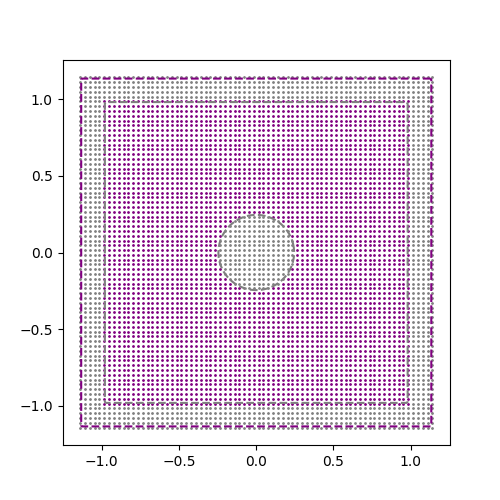

In [3]:
fluid_sdf = lambda x: sampleDomainSDF(x, domain, invert = True)
domain_sdf = lambda x: sampleDomainSDF(x, interiorDomain, invert = False)
obstacle_sdf = lambda points: sampleSDF(points, lambda x: getSDF('circle')['function'](x, torch.tensor(1/4).to(points.device)), invert = False)

box_sdf = lambda points: sampleSDF(points, lambda x: getSDF('box')['function'](x, torch.tensor([0.5,0.5]).to(points.device)))

inlet_sdf = lambda points: sampleSDF(points, operatorDict['translate'](lambda x: getSDF('box')['function'](x, torch.tensor([0.125,0.125]).to(points.device)), torch.tensor([-0.5,0.5]).to(points.device)), invert = False)
outlet_sdf = lambda points: sampleSDF(points, operatorDict['translate'](lambda x: getSDF('box')['function'](x, torch.tensor([0.125,0.125]).to(points.device)), torch.tensor([0.5,-0.5]).to(points.device)), invert = False)
outletBuffer_sdf = lambda points: sampleSDF(points, operatorDict['translate'](lambda x: getSDF('box')['function'](x, torch.tensor([0.25,0.25]).to(points.device)), torch.tensor([0.5,-0.5]).to(points.device)), invert = False)


regions = []

regions.append(buildRegion(sdf = domain_sdf, config = config, type = 'boundary', kind = 'constant'))
regions.append(buildRegion(sdf = obstacle_sdf, config = config, type = 'boundary', kind = 'zero'))
regions.append(buildRegion(sdf = fluid_sdf, config = config, type = 'fluid'))
# regions.append(buildRegion(sdf = inlet_sdf, config = config, type = 'inlet', dirichletValues={'densities': config['fluid']['rho0'], 'velocities': torch.tensor([1,0], device = device, dtype = dtype)}, updateValues = {'densities': 0, 'velocities': torch.tensor([0,0], device = device, dtype = dtype)}))

# regions.append(buildRegion(sdf = outlet_sdf, config = config, type = 'outlet'))
# regions.append(buildRegion(sdf = outletBuffer_sdf, config = config, type = 'buffer', bufferValues = ['densities', 'velocities', 'pressures']))

# regions.append(buildRegion(sdf = box_sdf, config = config, type = 'dirichlet', dirichletValues={'densities': 2.0, 'velocities': torch.tensor([1,2], device = device, dtype = dtype), 'pressures': lambda x: torch.where(x[:,0] > 0, 0.0, 1.0)}, updateValues = {'densities': 2.0}))


for region in regions:
    region = filterRegion(region, regions)


fig, axis = plt.subplots(1, 1, figsize=(5, 5), squeeze=False)
    
plotRegions(regions, axis[0,0], plotFluid = True, plotParticles = True)


In [4]:
from sphMath.sampling import sampleDivergenceFreeNoise

particleState, config, rigidBodies = initializeSimulation(scheme, config, regions)

velocities = sampleDivergenceFreeNoise(particleState, domain, config, nx * 2, octaves = 3, lacunarity = 2, persistence = 0.5, baseFrequency = 1, tileable = True, kind = 'perlin', seed = 45906734)
particleState.velocities[:] = velocities

particles = copy.deepcopy(particleState)
particleSystem = DeltaPlusSPHSystem(domain, None, 0., copy.deepcopy(particleState), 'momentum', None, rigidBodies = rigidBodies, regions = config['regions'], config = config)

for rigidBody in rigidBodies:
    particleState = updateBodyParticles(scheme, particleState, rigidBody)
    
config['timestep'] = {'CFL': CFL, 'dt': 1e-3, 'maxDt': 1e-2, 'minDt': 1e-6}
dt = computeTimestep(scheme, 1e-2, particleSystem.systemState, config, None)
print(dt)
config['timestep']['dt'] = dt

kineticEnergy = 0.5 * particleState.densities * (particleState.velocities ** 2).sum(1)

t = 0
E_k0 = 0.5 * particleState.masses * torch.linalg.norm(particleState.velocities, dim = -1)**2
E_k = 0.5 * particleState.masses * torch.linalg.norm(particleState.velocities, dim = -1)**2

rhoMin = particleState.densities.min().detach().cpu().item() / config['fluid']['rho0']
rhoMean = particleState.densities.mean().detach().cpu().item() / config['fluid']['rho0']
rhoMax = particleState.densities.max().detach().cpu().item() / config['fluid']['rho0']


initialVelocity = particleState.velocities.clone()
initialDensities = particleState.densities.clone()

initialKineticEnergy = 0.5 * particleState.masses / config['fluid']['rho0'] * particleState.densities * torch.linalg.norm(initialVelocity, dim = -1)**2

t = 0

[0 1]
[SPH] - Adaptive Timestep Update
	CFL: 0.3, maxDt: 0.01, minDt: 1e-06
	Diffusion: 0.01, deltaSPH_inviscid
	Fluid: 20, 0.1249999925494194, 2.171239
	Viscosity: 0.28785407543182373, Acoustic: 0.0008635621634311974, Acceleration: 0.009999999776482582
tensor(0.0009, device='cuda:0')


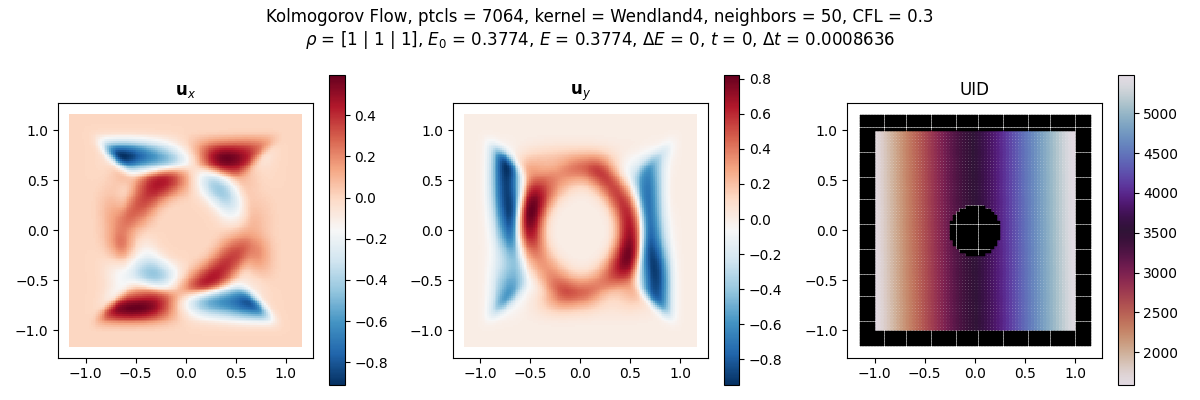

In [5]:
kineticEnergy = 0.5 * particleSystem.systemState.masses / config['fluid']['rho0'] * particleSystem.systemState.densities * torch.linalg.norm(particleSystem.systemState.velocities, dim = -1)**2

fig, axis = plt.subplots(1, 3, figsize = (12, 4), squeeze=False)

markerSize = 4
vxPlot = visualizeParticles(fig, axis[0,0], 
            particles = particleSystem.systemState, 
            domain = domain, 
            quantity = particleSystem.systemState.velocities, 
            which = 'fluid',
            mapping = '.x',
            cmap = 'RdBu_r',
            visualizeBoth=False,
            kernel = wrappedKernel,
            plotDomain = False,
            gridVisualization=True, markerSize=markerSize, streamLines=False)
# axis[0,0].set_title('Density')

vyPlot = visualizeParticles(fig, axis[0,1],
            particles = particleSystem.systemState, 
            domain = domain, 
            quantity = particleSystem.systemState.velocities, 
            which = 'both',
            # operation = 'curl',
            mapping = '.y',
            cmap = 'RdBu_r',
            visualizeBoth=True,
            kernel = wrappedKernel,
            plotDomain = False,
            gridVisualization=True, markerSize=markerSize)

uidPlot = visualizeParticles(fig, axis[0,2],
            particles = particleSystem.systemState, 
            domain = domain, 
            quantity = particleSystem.systemState.UIDs, 
            which = 'fluid',
            mapping = '.x',
            cmap = 'twilight_r',
            visualizeBoth=True,
            kernel = wrappedKernel,
            plotDomain = False,
            gridVisualization=False, markerSize=markerSize, streamLines=False)
axis[0,0].set_title(r'$\mathbf{u}_x$')
axis[0,1].set_title(r'$\mathbf{u}_y$')
axis[0,2].set_title(r'UID')


totalInitialEnergy = (initialKineticEnergy).sum().detach().cpu().item()
totalEnergy = (kineticEnergy).sum().detach().cpu().item()

fig.suptitle(f'Obstacle Flow, ptcls = {particleState.positions.shape[0]}, kernel = {kernel}, neighbors = {targetNeighbors:.2g}, CFL = {CFL}\n$\\rho$ = [{rhoMin:.4g} | {rhoMean:.4g} | {rhoMax:.4g}], $E_0$ = {totalInitialEnergy:.4g}, $E$ = {totalEnergy:.4g}, $\\Delta E$ = {totalEnergy - totalInitialEnergy:.4g}, $t$ = {t:.4g}, $\Delta t$ = {dt:.4g}')

fig.tight_layout()

In [6]:
imagePrefix = './images/ObstacleFlow/'
os.makedirs(imagePrefix, exist_ok = True)

fig.savefig(f'{imagePrefix}frame_{0:05d}.png', dpi = 100)


In [7]:
particles = copy.deepcopy(particleState)
particleSystem = DeltaPlusSPHSystem(domain, None, 0., copy.deepcopy(particleState), 'momentum', None, rigidBodies = rigidBodies, regions = config['regions'], config = config)

t = 0
timeLimit = 10
timesteps = int(timeLimit / dt)
plotInterval = 50

for i in (tq:=tqdm(range(timesteps))):
    particleSystem, currentState, updates = integrationScheme.function(particleSystem, dt, deltaPlusSPHScheme, config, priorStep = particleSystem.priorStep, verbose = False)
    
    if i % plotInterval == plotInterval - 1 or i == timesteps - 1:

        rhoMin = particleSystem.systemState.densities.min().detach().cpu().item() / config['fluid']['rho0']
        rhoMean = particleSystem.systemState.densities.mean().detach().cpu().item() / config['fluid']['rho0']
        rhoMax = particleSystem.systemState.densities.max().detach().cpu().item() / config['fluid']['rho0']

        kineticEnergy = 0.5 * particleSystem.systemState.masses / config['fluid']['rho0'] * particleSystem.systemState.densities * torch.linalg.norm(particleSystem.systemState.velocities, dim = -1)**2
        totalInitialEnergy = (initialKineticEnergy).sum().detach().cpu().item()
        totalEnergy = (kineticEnergy).sum().detach().cpu().item()

        fig.suptitle(f'Kolmogorov Flow, ptcls = {particleState.positions.shape[0]}, kernel = {kernel}, neighbors = {targetNeighbors:.2g}, CFL = {CFL}\n$\\rho$ = [{rhoMin:.4g} | {rhoMean:.4g} | {rhoMax:.4g}], $E_0$ = {totalInitialEnergy:.4g}, $E$ = {totalEnergy:.4g}, $\\Delta E$ = {totalEnergy - totalInitialEnergy:.4g}, $t$ = {t:.4g}, $\Delta t$ = {dt:.4g}')

        updatePlot(vxPlot, particleSystem.systemState, particleSystem.systemState.velocities)
        updatePlot(vyPlot, particleSystem.systemState, particleSystem.systemState.velocities)
        updatePlot(uidPlot, particleSystem.systemState, particleSystem.systemState.UIDs)

        fig.canvas.draw()
        fig.canvas.flush_events()
        fig.savefig(f'{imagePrefix}frame_{i:05d}.png', dpi = 100)
    # break
    # if i > 90:
        # break
    

  0%|          | 0/11579 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import subprocess
import shlex
output = 'timestamp'
scale = 1280

command = '/usr/bin/ffmpeg -loglevel warning -hide_banner -y -framerate 50 -f image2 -pattern_type glob -i '+ imagePrefix + '/frame_*.png -c:v libx264 -b:v 20M -r 50 ' + imagePrefix + '/output.mp4'
commandB = f'/usr/bin/ffmpeg -loglevel warning -hide_banner -y -i {imagePrefix}/output.mp4 -vf "fps=50,scale={scale}:-1:flags=lanczos,palettegen" {imagePrefix}/palette.png'
commandC = f'/usr/bin/ffmpeg -loglevel warning -hide_banner -y -i {imagePrefix}/output.mp4 -i {imagePrefix}/palette.png -filter_complex "fps=50,scale={scale}:-1:flags=lanczos[x];[x][1:v]paletteuse" {imagePrefix}/output.gif'

print('Creating video from  frames (frame count: {})'.format(len(os.listdir(imagePrefix))))
subprocess.run(shlex.split(command))
print('Creating gif palette')
subprocess.run(shlex.split(commandB))
print('Creating gif')
subprocess.run(shlex.split(commandC))
print('Done')


[SPH] - Adaptive Timestep Update
	CFL: 0.3, maxDt: 0.01, minDt: 1e-06
	Diffusion: 0.1, deltaSPH_inviscid
	Fluid: 10, 0.125, 2.171239
	Viscosity: 0.057570815086364746, Acoustic: 0.0017271244432777166, Acceleration: 0.009999999776482582
tensor(0.0017)


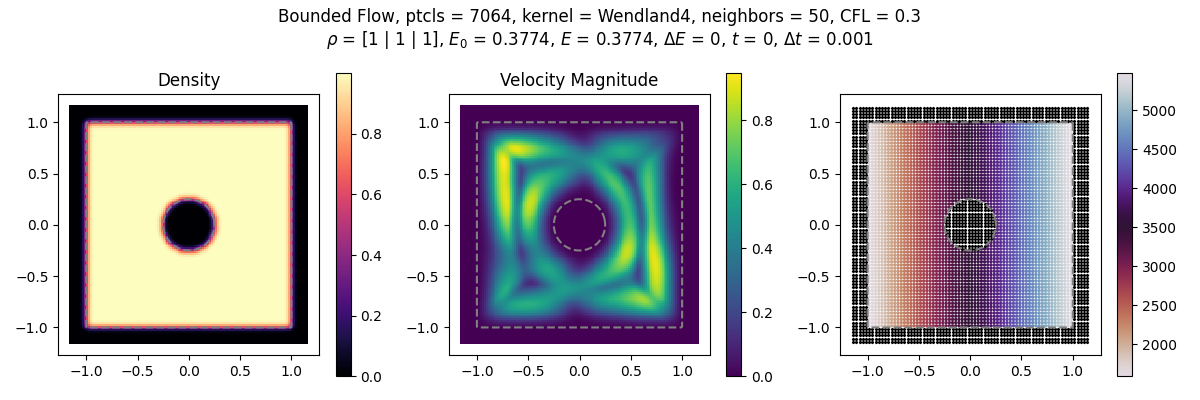

In [20]:
import matplotlib.patches as patches

kineticEnergy = 0.5 * particleSystem.systemState.masses / config['fluid']['rho0'] * particleSystem.systemState.densities * torch.linalg.norm(particleSystem.systemState.velocities, dim = -1)**2

fig, axis = plt.subplots(1, 3, figsize = (12, 4), squeeze=False)

markerSize = 2
vxPlot = visualizeParticles(fig, axis[0,0], 
            particles = particleSystem.systemState, 
            domain = domain, 
            quantity = particleSystem.systemState.densities, 
            which = 'fluid',
            mapping = 'L2',
            cmap = 'magma',
            visualizeBoth=True,
            kernel = wrappedKernel,
            plotDomain = False,
            gridVisualization=True, markerSize=markerSize)
axis[0,0].set_title('Density')

vyPlot = visualizeParticles(fig, axis[0,1],
            particles = particleSystem.systemState, 
            domain = domain, 
            quantity = particleSystem.systemState.velocities, 
            which = 'fluid',
            mapping = 'L2',
            cmap = 'viridis',
            visualizeBoth=True,
            kernel = wrappedKernel,
            plotDomain = False,
            gridVisualization=True, markerSize=markerSize)
axis[0,1].set_title('Velocity Magnitude')

uidPlot = visualizeParticles(fig, axis[0,2],
            particles = particleSystem.systemState, 
            domain = domain, 
            quantity = particleSystem.systemState.UIDs, 
            which = 'fluid',
            mapping = ',x',
            cmap = 'twilight_r',
            visualizeBoth=True,
            kernel = wrappedKernel,
            plotDomain = False,
            gridVisualization=False, markerSize=markerSize)

# for ax in axis.flatten():
#     ax.scatter(
#         particleSystem.systemState.positions[particleSystem.systemState.kinds > 1,0].cpu().numpy(),
#         particleSystem.systemState.positions[particleSystem.systemState.kinds > 1,1].cpu().numpy(),
#         marker = 'o',
#         s = 4,
#     )

for ax in axis.flatten():
    plotRegions(regions, ax, plotFluid = False, plotParticles = False)

totalInitialEnergy = (initialKineticEnergy).sum().detach().cpu().item()
totalEnergy = (kineticEnergy).sum().detach().cpu().item()

fig.suptitle(f'Bounded Flow, ptcls = {particleState.positions.shape[0]}, kernel = {kernel}, neighbors = {targetNeighbors:.2g}, CFL = {CFL}\n$\\rho$ = [{rhoMin:.4g} | {rhoMean:.4g} | {rhoMax:.4g}], $E_0$ = {totalInitialEnergy:.4g}, $E$ = {totalEnergy:.4g}, $\\Delta E$ = {totalEnergy - totalInitialEnergy:.4g}, $t$ = {t:.4g}, $\Delta t$ = {dt:.4g}')

fig.tight_layout()

In [21]:
imagePrefix = './images/bounded_flow/'
os.makedirs(imagePrefix, exist_ok = True)

fig.savefig(f'{imagePrefix}frame_{0:05d}.png', dpi = 100)


In [22]:
particles = copy.deepcopy(particleState)
particleSystem = WeaklyCompressibleSystem(domain, None, 0., copy.deepcopy(particleState), 'momentum', None)

t = 0
timeLimit = 4
timesteps = int(timeLimit / dt)
plotInterval = 16
# timesteps = 64

for i in (tq:=tqdm(range(timesteps))):
    particleSystem, currentState, updates = integrationScheme.function(particleSystem, dt, deltaPlusSPHScheme, config, priorStep = particleSystem.priorStep, verbose = False)
    particleSystem.priorStep = [updates[-1], currentState[-1]]
    t += dt
    dx, *_ = solveShifting(particleSystem, 0.1, config, verbose = False)
    
    passiveMask = updates[-1].passive == 0 if updates[-1].passive is not None else torch.ones_like(updates[-1].UIDs, dtype = torch.bool)
    particleSystem.systemState.positions[passiveMask,:] += dx[passiveMask,:]
    particleSystem.systemState, emitted = processInlets(particleSystem.systemState, config, domain)
    if emitted > 0:
        particleSystem.neighborhoodInfo = None
        particleSystem.priorStep = None
    # dt = computeTimestep(dt, particleSystem, updates[-1], config, verbose = False)

    
    if i % plotInterval == plotInterval - 1 or i == timesteps - 1:

        rhoMin = particleSystem.systemState.densities.min().detach().cpu().item() / config['fluid']['rho0']
        rhoMean = particleSystem.systemState.densities.mean().detach().cpu().item() / config['fluid']['rho0']
        rhoMax = particleSystem.systemState.densities.max().detach().cpu().item() / config['fluid']['rho0']

        kineticEnergy = 0.5 * particleSystem.systemState.masses / config['fluid']['rho0'] * particleSystem.systemState.densities * torch.linalg.norm(particleSystem.systemState.velocities, dim = -1)**2
        totalInitialEnergy = (initialKineticEnergy).sum().detach().cpu().item()
        totalEnergy = (kineticEnergy).sum().detach().cpu().item()

        fig.suptitle(f'Bounded Flow, ptcls = {particleState.positions.shape[0]}, kernel = {kernel}, neighbors = {targetNeighbors:.2g}, CFL = {CFL}\n$\\rho$ = [{rhoMin:.4g} | {rhoMean:.4g} | {rhoMax:.4g}], $E_0$ = {totalInitialEnergy:.4g}, $E$ = {totalEnergy:.4g}, $\\Delta E$ = {totalEnergy - totalInitialEnergy:.4g}, $t$ = {t:.4g}, $\Delta t$ = {dt:.4g}')

        updatePlot(vxPlot, particleSystem.systemState, particleSystem.systemState.densities)
        updatePlot(vyPlot, particleSystem.systemState, particleSystem.systemState.velocities)
        updatePlot(uidPlot, particleSystem.systemState, particleSystem.systemState.UIDs)

        fig.canvas.draw()
        fig.canvas.flush_events()
        fig.savefig(f'{imagePrefix}frame_{i:05d}.png', dpi = 100)
    # break
        
    

  0%|          | 0/4000 [00:00<?, ?it/s]

In [20]:

from torch.profiler import profile, record_function, ProfilerActivity
profiledSystem = copy.deepcopy(particleSystem)

with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
    profiledSystem, currentState, updates = integrationScheme.function(profiledSystem, dt, deltaPlusSPHScheme, config, priorStep = profiledSystem.priorStep, verbose = False)
    profiledSystem.priorStep = [updates[-1], currentState[-1]]
    t += dt
    dx, *_ = solveShifting(profiledSystem, 0.1, config, verbose = False)
    
    passiveMask = updates[-1].passive == 0 if updates[-1].passive is not None else torch.ones_like(updates[-1].UIDs, dtype = torch.bool)
    profiledSystem.systemState.positions[passiveMask,:] += dx[passiveMask,:]
    profiledSystem.systemState, emitted = processInlets(profiledSystem.systemState, config, domain)
    if emitted > 0:
        profiledSystem.neighborhoodInfo = None
        profiledSystem.priorStep = None
    # dt = computeTimestep(dt, particleSystem, updates[-1], config, verbose = False)

print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                  [Integration] Butcher         0.14%     131.950us        68.83%      66.363ms      66.363ms             1  
                              [Integration] Butcher: k1         0.03%      29.760us        63.11%      60.847ms      60.847ms             1  
                              [Integration] Update Step         0.33%     315.349us        63.08%      60.817ms      60.817ms             1  
                                     [SPH] - [Shifting]         0.14%     130.750us        27.78%      26.783ms      26.783ms             1  
      

In [21]:

prof.export_chrome_trace("profile.json")

buffer - zero


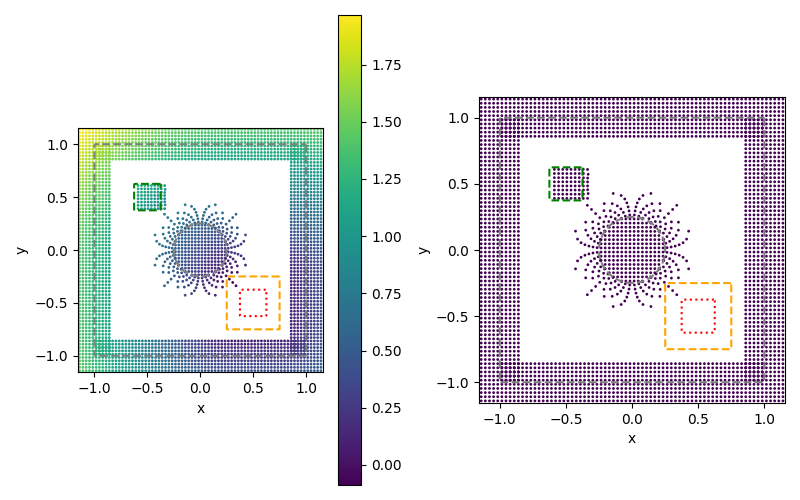

In [26]:
fig, axis = plt.subplots(1, 2, figsize=(8, 5), squeeze=False)

r = 4
print(regions[r]['type'], '-', regions[r]['kind'])

sdfValue, sdfNormal = regions[r]['sdf'](particleSystem.systemState.positions)

sc = axis[0,0].scatter(particleSystem.systemState.positions[:,0].detach().cpu().numpy(), particleSystem.systemState.positions[:,1].detach().cpu().numpy(), c = sdfValue.detach().cpu().numpy(), s = 1)
fig.colorbar(sc, ax = axis[0,0])

axis[0,1].scatter(particleSystem.systemState.positions[:,0].detach().cpu().numpy(), particleSystem.systemState.positions[:,1].detach().cpu().numpy(), c = torch.logical_and(sdfValue < 0, particleSystem.systemState.kinds != 2).detach().cpu().numpy(), s = 1)

for ax in axis.flatten():
    ax.set_xlim(domain.min[0].item(), domain.max[0].item())
    ax.set_ylim(domain.min[1].item(), domain.max[1].item())
    ax.set_aspect('equal')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plotRegions(regions, ax, plotFluid = False, plotParticles = False)
    
fig.tight_layout()

# display(fig)
    # ax.grid()
    # ax.legend()

In [23]:
import subprocess
import shlex
output = 'timestamp'
scale = 1280

command = '/usr/bin/ffmpeg -loglevel warning -hide_banner -y -framerate 50 -f image2 -pattern_type glob -i '+ imagePrefix + '/frame_*.png -c:v libx264 -b:v 20M -r 50 ' + imagePrefix + '/output.mp4'
commandB = f'ffmpeg -loglevel warning -hide_banner -y -i {imagePrefix}/output.mp4 -vf "fps=50,scale={scale}:-1:flags=lanczos,palettegen" {imagePrefix}/palette.png'
commandC = f'ffmpeg -loglevel warning -hide_banner -y -i {imagePrefix}/output.mp4 -i {imagePrefix}/palette.png -filter_complex "fps=50,scale={scale}:-1:flags=lanczos[x];[x][1:v]paletteuse" {imagePrefix}/output.gif'

print('Creating video from  frames (frame count: {})'.format(len(os.listdir(imagePrefix))))
subprocess.run(shlex.split(command))
print('Creating gif palette')
subprocess.run(shlex.split(commandB))
print('Creating gif')
subprocess.run(shlex.split(commandC))
print('Done')


Creating video from  frames (frame count: 251)
Creating gif palette


[Parsed_palettegen_2 @ 0x5649936dc980] Dupped color: FF000004
[Parsed_palettegen_2 @ 0x5649936dc980] Dupped color: FFFCF8BA
    Last message repeated 1 times
[Parsed_palettegen_2 @ 0x5649936dc980] Dupped color: FFFDF9BB


Creating gif
Done


In [17]:

print(commandB)
print(commandC)

ffmpeg -loglevel warning -hide_banner -y -i ./images//output.mp4 -vf "fps=20,scale=1280:-1:flags=lanczos,palettegen" ./images//palette.png
ffmpeg -loglevel warning -hide_banner -y -i ./images//output.mp4 -i ./images//palette.png -filter_complex "fps=20,scale=1280:-1:flags=lanczos[x];[x][1:v]paletteuse" ./images//output.gif


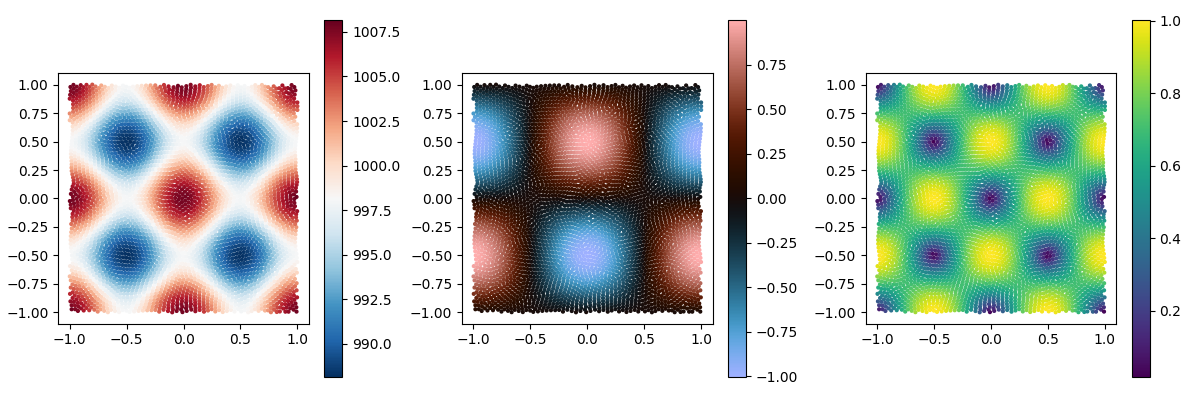

In [25]:
fig, axis = plt.subplots(1, 3, figsize = (12, 4), squeeze=False)

plotParticles=particleSystem.systemState

vxPlot = visualizeParticles(fig, axis[0,0], 
            particles = plotParticles, 
            domain = domain, 
            quantity = plotParticles.densities, 
            which = 'both',
            mapping = '.x',
            cmap = 'RdBu_r',
            visualizeBoth=True,
            kernel = wrappedKernel,
            plotDomain = False,
            gridVisualization=False)

vyPlot = visualizeParticles(fig, axis[0,1],
            particles = plotParticles, 
            domain = domain, 
            quantity = plotParticles.velocities, 
            which = 'both',
            mapping = '.y',
            cmap = 'berlin',
            visualizeBoth=True,
            kernel = wrappedKernel,
            plotDomain = False,
            gridVisualization=False)

vMagPlot = visualizeParticles(fig, axis[0,2],
            particles = plotParticles, 
            domain = domain, 
            quantity = plotParticles.velocities, 
            which = 'both',
            mapping = 'L2',
            visualizeBoth=True,
            kernel = wrappedKernel,
            plotDomain = False,
            gridVisualization=False,
            streamLines=False)

fig.tight_layout()

In [29]:

from torch.profiler import profile, record_function, ProfilerActivity
profiledSystem = copy.deepcopy(particleSystem)

with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
    profiledSystem, currentState, updates = integrationScheme.function(profiledSystem, 1e-3, deltaPlusSPHScheme, config, priorStep = profiledSystem.priorStep, verbose = False)
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

# prof.export_chrome_trace("profile.json")

---------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
---------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  [Integration] Butcher         0.03%      86.270us        99.98%     297.353ms     297.353ms             1  
              [Integration] Butcher: k1         0.01%      21.300us        98.35%     292.501ms     292.501ms             1  
              [Integration] Update Step         1.54%       4.585ms        98.34%     292.480ms     292.480ms             1  
                            SPHGradient         1.13%       3.352ms        30.68%      91.245ms      18.249ms             5  
                            aten::index        25.72%      76.495ms        26.61%      79.155ms     618.400us         

In [30]:
shiftSystem = copy.deepcopy(particleSystem)

In [ ]:
from sphMath.modules.surfaceDetection import computeNormalsMaronne, detectFreeSurfaceMaronne, computeColorField, detectFreeSurfaceColorFieldGradient, detectFreeSurfaceBarecasco, expandFreeSurfaceMask, computeLambdaGrad

# def computeLambdaGrad(particles, domain, wrappedKernel, sparseNeighborhood, supportScheme, solverConfig, L, lambdas):
    # return sph_op(particles, particles, domain, wrappedKernel, sparseNeighborhood, operation = 'gradient', gradientMode = 'difference', supportScheme = supportScheme, gradientRenormalizationMatrix=(L,L), quantity = (lambdas, lambdas))

In [33]:
def computeDeltaShifting(particles, domain, wrappedKernel, sparseNeighborhood, config):
    rho0 = config.get('fluid', {}).get('referenceDensity', 998)
    dx = config.get('particle', {}).get('dx', torch.pow(particles.masses / rho0, 1/particles.positions.shape[1]).cpu().item())
    
    W_0 = wrappedKernel.eval(torch.tensor(dx / particles.supports * wrappedKernel.kernelScale), torch.tensor(particles.supports), dim = domain.dim)
    
    rij, xij = computeDistanceTensor(sparseNeighborhood, False, mode = 'gather')
    
    i,j = sparseNeighborhood.row, sparseNeighborhood.col
    k = wrappedKernel.eval(xij, particles.supports[i]) / W_0
    gradK = wrappedKernel.evalGrad(xij, particles.supports[i])
    
    R = config.get('shifting', {}).get('R', 0.25)
    n = config.get('shifting', {}).get('n', 4)
    term = (1 + R * torch.pow(k, n))
    densityTerm = particles.masses[j] / (particles.densities[i] + particles.densities[j])
    phi_ij = 1
    
    scalarTerm = term * densityTerm * phi_ij
    shiftAmount = scatter_sum(scalarTerm.view(-1,1) * gradK, i, dim = 0, dim_size = particles.positions.shape[0])
    
    CFL = config.get('shifting', {}).get('CFL', 0.3)
    if config.get('shifting', {}).get('computeMach', False) == False:
        Ma = 0.1
    else:
        Ma = torch.amax(torch.linalg.norm(particles.velocities, dim = -1)) / particles.soundspeeds.view(-1,1)
    shiftScaling = -CFL * Ma * (particles.supports / wrappedKernel.kernelScale * 2)**2
    return shiftScaling.view(-1,1) * shiftAmount
    
    


In [34]:
def solveShifting(SPHSystem, dt, config, verbose = False):
    domain          = config['domain']
    wrappedKernel   = config['kernel']
    particles       = copy.deepcopy(SPHSystem.systemState)
    neighborhood    = SPHSystem.neighborhoodInfo
    
    shiftIters = config.get('shifting', {}).get('maxIterations', 1)
    summationDensity = config.get('shifting', {}).get('summationDensity', True)
    freeSurface = config.get('shifting', {}).get('freeSurface', False)
    freeSurfaceScheme = config.get('shifting', {}).get('surfaceDetection', 'Barecasco')
    shiftingScheme = config.get('shifting', {}).get('scheme', 'delta')
    normalScheme = config.get('shifting', {}).get('normalScheme', 'lambda')
    projectionScheme = config.get('shifting', {}).get('projectionScheme', 'mat')
    surfaceScaling = config.get('shifting', {}).get('surfaceScaling', 0.1)
    shiftingThreshold = config.get('shifting', {}).get('threshold', 0.5)
    rho0 = config.get('fluid', {}).get('referenceDensity', 998)
    spacing = config.get('particle', {}).get('dx', torch.pow(particles.masses / rho0, 1/particles.positions.shape[1]).cpu().item())
    
    
    
    for i in range(shiftIters):            
        neighborhood, sparseNeighborhood = buildNeighborhood(particles, particles, domain, verletScale = config['verletScale'], mode = 'superSymmetric', priorNeighborhood=neighborhood,verbose = verbose, neighborhoodAlgorithm=config.get('neighborhoodAlgorithm', 'compact'))         
        sparseNeighborhood = filterNeighborhoodByKind(particles, sparseNeighborhood, which = 'normal')    
        actualNeighbors = filterNeighborhood(sparseNeighborhood)
        numNeighbors = coo_to_csr(actualNeighbors).rowEntries
        
        if summationDensity:
            particles.densities = computeDensity(particles, particles, domain, wrappedKernel, actualNeighbors, 'gather')
            
        if freeSurface:
            n = None
            lMin = None
            if freeSurfaceScheme == 'Maronne':
                C, L, eVals = computeCovarianceMatrices(particles, particles, domain, wrappedKernel, sparseNeighborhood, config)
                n, lMin = computeNormalsMaronne(particles, particles, domain, wrappedKernel, sparseNeighborhood, 'gather', config, L, eVals)
                fs, cA, cB = detectFreeSurfaceMaronne(particles, particles, domain, wrappedKernel, sparseNeighborhood, 'gather', config, n)
                n = computeLambdaGrad(particles, domain, wrappedKernel, sparseNeighborhood, 'gather', config, L, lMin)
            elif freeSurfaceScheme == 'colorGrad':
                color, colorGrad = computeColorField(particles, particles, domain, wrappedKernel, sparseNeighborhood, 'gather', config)
                fs = detectFreeSurfaceColorFieldGradient(particles, particles, domain, wrappedKernel, sparseNeighborhood, 'gather', config, color, colorGrad)
                n = torch.nn.functional.normalize(colorGrad, p=2, dim=1)
            elif freeSurfaceScheme == 'Barecasco':
                fs = detectFreeSurfaceBarecasco(particles, particles, domain, wrappedKernel, sparseNeighborhood, 'gather', config)
            else:
                raise ValueError(f'Unknown surface detection scheme {freeSurfaceScheme}')
            fsMask = expandFreeSurfaceMask(fs, sparseNeighborhood, config)

        if shiftingScheme == 'IPS':
            raise NotImplementedError('IPS not implemented')
        else:
            update = -computeDeltaShifting(particles, domain, wrappedKernel, sparseNeighborhood, config)
        
        if freeSurface:
            if (normalScheme == 'lambda' and freeSurfaceScheme == 'Maronne') or (normalScheme=='color' and freeSurfaceScheme == 'colorGrad'):
                pass
            else:
                if normalScheme == 'lambda':
                    C, L, eVals = computeCovarianceMatrices(particles, particles, domain, wrappedKernel, sparseNeighborhood, config)
                    n, lMin = computeNormalsMaronne(particles, particles, domain, wrappedKernel, sparseNeighborhood, 'gather', config, L, eVals)
                    n = computeLambdaGrad(particles, domain, wrappedKernel, sparseNeighborhood, 'gather', config, L, lMin)
                    n = torch.nn.functional.normalize(n, p=2, dim=1)
                elif normalScheme == 'color':
                    color, colorGrad = computeColorField(particles, particles, domain, wrappedKernel, sparseNeighborhood, 'gather', config)
                    n = torch.nn.functional.normalize(colorGrad, p=2, dim=1)
                else:
                    raise ValueError(f'Unknown normal scheme {normalScheme}')
                           
            if lMin is None:
                C, L, eVals = computeCovarianceMatrices(particles, particles, domain, wrappedKernel, sparseNeighborhood, config)
                n, lMin = computeNormalsMaronne(particles, particles, domain, wrappedKernel, sparseNeighborhood, 'gather', config, L, eVals)
                
            if projectionScheme == 'dot':
                result = update + torch.einsum('ij,ij->i', update, n).view(-1,1) * n
                update[fsMask > 0.5] = result[fsMask > 0.5] * surfaceScaling
                update[lMin < 0.4] = 0
            elif projectionScheme == 'mat':
                nMat = torch.einsum('ij, ik -> ikj', n, n)
                M = torch.diag_embed(particles.positions.new_ones(particles.positions.shape)) - nMat
                result = torch.bmm(M, update.unsqueeze(-1)).squeeze(-1)
                update[fsMask > 0.5] = result[fsMask > 0.5]
                update[lMin < 0.4] = 0
                update[fs > 0.5] = update[fs > 0.5] * surfaceScaling
            else:
                update[lMin < 0.4] = 0
                update[fs > 0.5] = 0
                
        spacing = torch.pow(particles.masses / rho0, 1/particles.positions.shape[1])
        update = torch.clamp(update, -shiftingThreshold * spacing.view(-1,1), shiftingThreshold * spacing.view(-1,1))
        update[particles.kind != 0] = 0
        particles.positions -= update
                    
    dx = particles.positions - particleSystem.systemState.positions
    
    return dx
        
        
    
    

In [ ]:
                           # update[fs > 0.5] = 0
                        
                with record_function("[Shifting] - Shift Iteration [5 - Update]"):
                    spacing = config['particle']['dx']
                    # print(
                    #     f'Iter: {i}, Threshold {config["shifting"]["threshold"] * spacing}, max Update = {update.max()} Ratio {update.max() / (config["shifting"]["threshold"] * spacing)}')

                    update = torch.clamp(update, -config['shifting']['threshold'] * spacing, config['shifting']['threshold'] * spacing)
                    update[boundaryMarker != 0,:] = 0
                    # print(f'Update: {update.max()} Ratio: {update.max() / (config["shifting"]["threshold"] * spacing)}')
                    # update = torch.clamp(update, -config['shifting']['threshold'] * spacing, config['shifting']['threshold'] * spacing)
                    particleState['positions'] = particleState['positions'] - update

                # print(f'J: {J.abs().max()}')
        dx = particleState['positions'] - initialPositions
        particleState['positions'] = initialPositions
        particleState['densities'] = initialDensities

        simulationState['fluid']['positions'] = particleState['positions'][:numParticles]
        simulationState['fluid']['densities'] = particleState['densities'][:numParticles]

        if boundaryParticleState is not None:
            simulationState['boundary']['positions'] = initialBoundaryPositions
            simulationState['boundary']['densities'] = initialBoundaryDensities

        dx = dx[:numParticles]

        if 'neighborhood' in simulationState['fluid']:
            if 'boundary' not in simulationState:
                simulationState['fluid']['neighborhood'] = particleState['neighborhood']

        return dx, overallStates